# Data Randomization Tests

## Packages and Presets

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from torchvision import models


# confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# append grandparent directory to path to make sure we can access the utils file
import sys

sys.path.append("../..")
from utils.utils import (
    get_pneumonia_images,
    PneumoniaDataset,
    set_all_seeds,
    test,
    EarlyStopping,
)

import warnings
warnings.filterwarnings("ignore")

In [2]:

SEED = 42
VALIDATION_SIZE = 0.2

TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # use pretrained resnet 50
        self.resnet = models.resnet50(pretrained=True)
        # replace fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.LazyLinear(2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # return one output for binary classification with BCEWithLogitsLoss
            nn.Linear(2048, 2),
        )

    def forward(self, x):
        # squeeze to make sure dimension is compatible with BCEWithLogitsLoss
        return self.resnet(x)


## Loading the Data

In [4]:
train_images, train_labels = get_pneumonia_images("../data/chest_xray/train")
val_images, val_labels = get_pneumonia_images("../data/chest_xray/val")
test_images, test_labels = get_pneumonia_images("../data/chest_xray/test")

# Since there are so few images (16 in total) in the validation set,
# we decided to first concatenate the train and validation images and then
# in a second step split this concatenated dateset into train and enlargened
# validation set. Further, we will make sure that the classes are similarly
# unbalanced in the validation set as in the training set. In the current
# validation set, this is not the case.
train_images_concat = train_images + val_images
train_labels_concat = np.concatenate([train_labels, val_labels])

# overwrite names for memory efficiency
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images_concat,
    train_labels_concat,
    test_size=VALIDATION_SIZE,
    random_state=SEED,
    stratify=train_labels_concat,
)


Reading PNEUMONIA test images: 100%|██████████| 390/390 [00:01<00:00, 317.53it/s]


In [5]:
# randomize the labels of the training data only using np.permutation
# see https://github.com/adebayoj/sanity_checks_saliency/blob/master/src/train_cnn_models.py
np.random.seed(SEED)
train_labels_permuted = np.random.permutation(train_labels)


test_transforms = transforms.Compose(
    [transforms.CenterCrop(224), transforms.ToTensor()]
)

test_set = PneumoniaDataset(test_images, test_labels, transforms=test_transforms)

test_loader = DataLoader(
    test_set, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory=True
)

In [6]:
# loss function that will be used for testing the model
num_0 = np.sum(train_labels_permuted == 0)
num_1 = np.sum(train_labels_permuted== 1)
weight = torch.tensor(
    [
        (1/num_0) * (num_0 + num_1) / 2.0,
        (1/num_1) * (num_0 + num_1) / 2.0
        
    ], dtype = torch.float32
).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight = weight)

## CNN with True Labels

In [7]:
# load the model
set_all_seeds(SEED)

cnn_not_permuted = CNN().to(DEVICE)
checkpoint = torch.load("../models/cnn_all_unfrozen.pth", map_location=DEVICE)
cnn_not_permuted.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
test_loss, test_f1_score, test_balanced_accuracy, model_probs, y_true = test(
    cnn_not_permuted, test_loader, criterion, device=DEVICE
)

print(confusion_matrix(y_true, model_probs.round()))

Test Loss: 1.3815765224397183
Test F1 Score: 0.9050410316529894
Test Balanced Accuracy: 0.8303418803418803
[[157  77]
 [  4 386]]


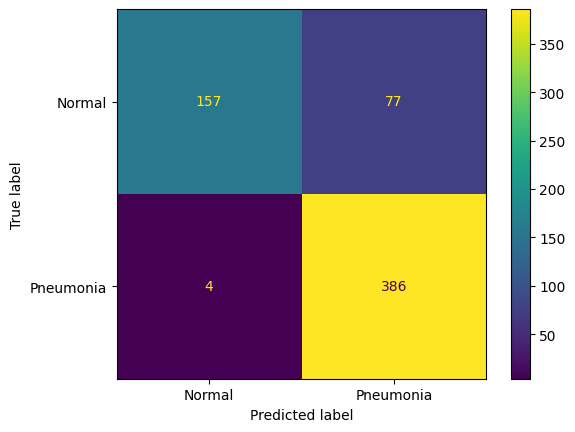

In [9]:
# Plot confusion matrix
labels = y_true
preds = model_probs.round()
cm  = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [10]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)


print(f"Accuracy of the model is {accuracy:.2f}")
print(f"Balanced accuracy of the model is {test_balanced_accuracy:.2f}")
print(f"Recall of the model is {recall:.2f}")
print(f"Precision of the model is {precision:.2f}")
print(f"F1 Score of the model is {test_f1_score:.2f}")

Accuracy of the model is 0.87
Balanced accuracy of the model is 0.83
Recall of the model is 0.99
Precision of the model is 0.83
F1 Score of the model is 0.91


## CNN with Permuted Labels

In [11]:
# load the model
set_all_seeds(SEED)

cnn_permuted = CNN().to(DEVICE)
checkpoint = torch.load("../models/cnn_permuted_all_unfrozen.pth", map_location=DEVICE)
cnn_permuted.load_state_dict(checkpoint)

<All keys matched successfully>

In [12]:
test_loss, test_f1_score, test_balanced_accuracy, model_probs, y_true = test(
    cnn_permuted, test_loader, criterion, device=DEVICE
)

print(confusion_matrix(y_true, model_probs.round()))

Test Loss: 4.102112889289856
Test F1 Score: 0.7238723872387238
Test Balanced Accuracy: 0.5158119658119658
[[ 44 190]
 [ 61 329]]


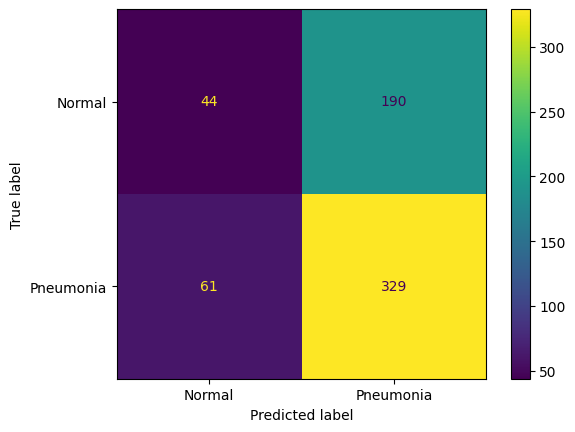

In [13]:
# Plot confusion matrix
labels = y_true
preds = model_probs.round()
cm  = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [14]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)


print(f"Accuracy of the model is {accuracy:.2f}")
print(f"Balanced accuracy of the model is {test_balanced_accuracy:.2f}")
print(f"Recall of the model is {recall:.2f}")
print(f"Precision of the model is {precision:.2f}")
print(f"F1 Score of the model is {test_f1_score:.2f}")

Accuracy of the model is 0.60
Balanced accuracy of the model is 0.52
Recall of the model is 0.84
Precision of the model is 0.63
F1 Score of the model is 0.72
